## What is a Knowledge Graph

A Knowledge Graph is a set of data points connected by relations that describe a domain, for instance, a business, an organization, or a field of study. It is a powerful way of representing data because Knowledge Graphs can be built automatically and can then be explored to reveal new insights about the domain.

The concept of Knowledge Graphs borrows from the Graph Theory. In this particular representation, we store data as:

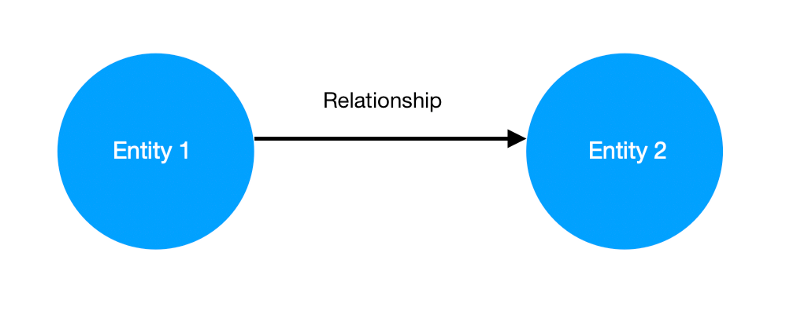

Entity 1 and Entity 2 are called nodes and the Relationship is called an edge. Of course, in a real-world knowledge graph, there are lots of entities and relationships and there is more than one way to arrive at one entity starting from another.

Usually, these types of graphs is modeled with triples, which are sets of three items like (subject, verb, object), with the verb being the relationship between the subject and the object - for example (London, is_capital, England).

In [1]:
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [3]:
!pip install beautifulsoup4

     |████████████████████████████████| 115 kB 420 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [22]:
import re
import pandas as pd
# import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [26]:
import pysrt

subs = pysrt.open('captions/_NvKMga-o2I(a.en).srt')
candidate_sentences = pd.DataFrame({'sentence': [s.text for s in subs]})

In [27]:
candidate_sentences


,sentence
0,good morning family how are y'all doing
1,today well praise the Lord I'm excited
2,to be here today I I I have some things
3,on my heart we're going to pray about um
4,you know a lot of people I guess I C
...,...
1303,a smile on your face and a song in your
1304,heart Jesus loves you so much and we
1305,love you and we'll see you again
1306,tomorrow God bless you all have a


In [7]:
doc = nlp("confused and frustrated, connie decides to leave on her own.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


### Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

In [6]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [7]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [28]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 1308/1308 [00:06<00:00, 195.18it/s]


In [29]:
entity_pairs[10:20]

[['President Trump', 'the'],
 ['', ''],
 ['winning', 'the'],
 ['whole world people', ''],
 ['that', 'people'],
 ['that', 'people'],
 ['', 'most  part'],
 ['', ''],
 ['when  they', 'that'],
 ['', '']]

### Relation / Predicate Extraction


In [32]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [33]:
get_relation("John completed the task")


'completed'

In [34]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 1308/1308 [00:07<00:00, 179.51it/s]


In [35]:
pd.Series(relations).value_counts()[:50]


thank         50
going         39
's            36
is            31
want          30
said          26
have          26
I             24
say           20
saw           19
'm            18
do            18
be            17
believe       15
know          15
was           14
're           14
got           13
find          13
are           11
praise         9
telling        9
you            9
get            8
thought        8
think          8
told           7
father         7
learn          7
need           7
see            7
like           7
done           7
had            6
pray           6
give           6
take           6
to             6
we             5
of             5
for            5
keep           5
going to       5
trying         5
watching       4
saying         4
call           4
did            4
watch          4
talk about     4
Name: count, dtype: int64

### Build a Knowledge Graph


In [36]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,how morning y',,doing
1,today I,today Lord,praise
2,I I,things,have
3,we,heart,going
4,I,I,guess
...,...,...,...
1303,,your,smile on
1304,heart Jesus,you,loves
1305,we,you,love
1306,tomorrow God,a,bless


In [51]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

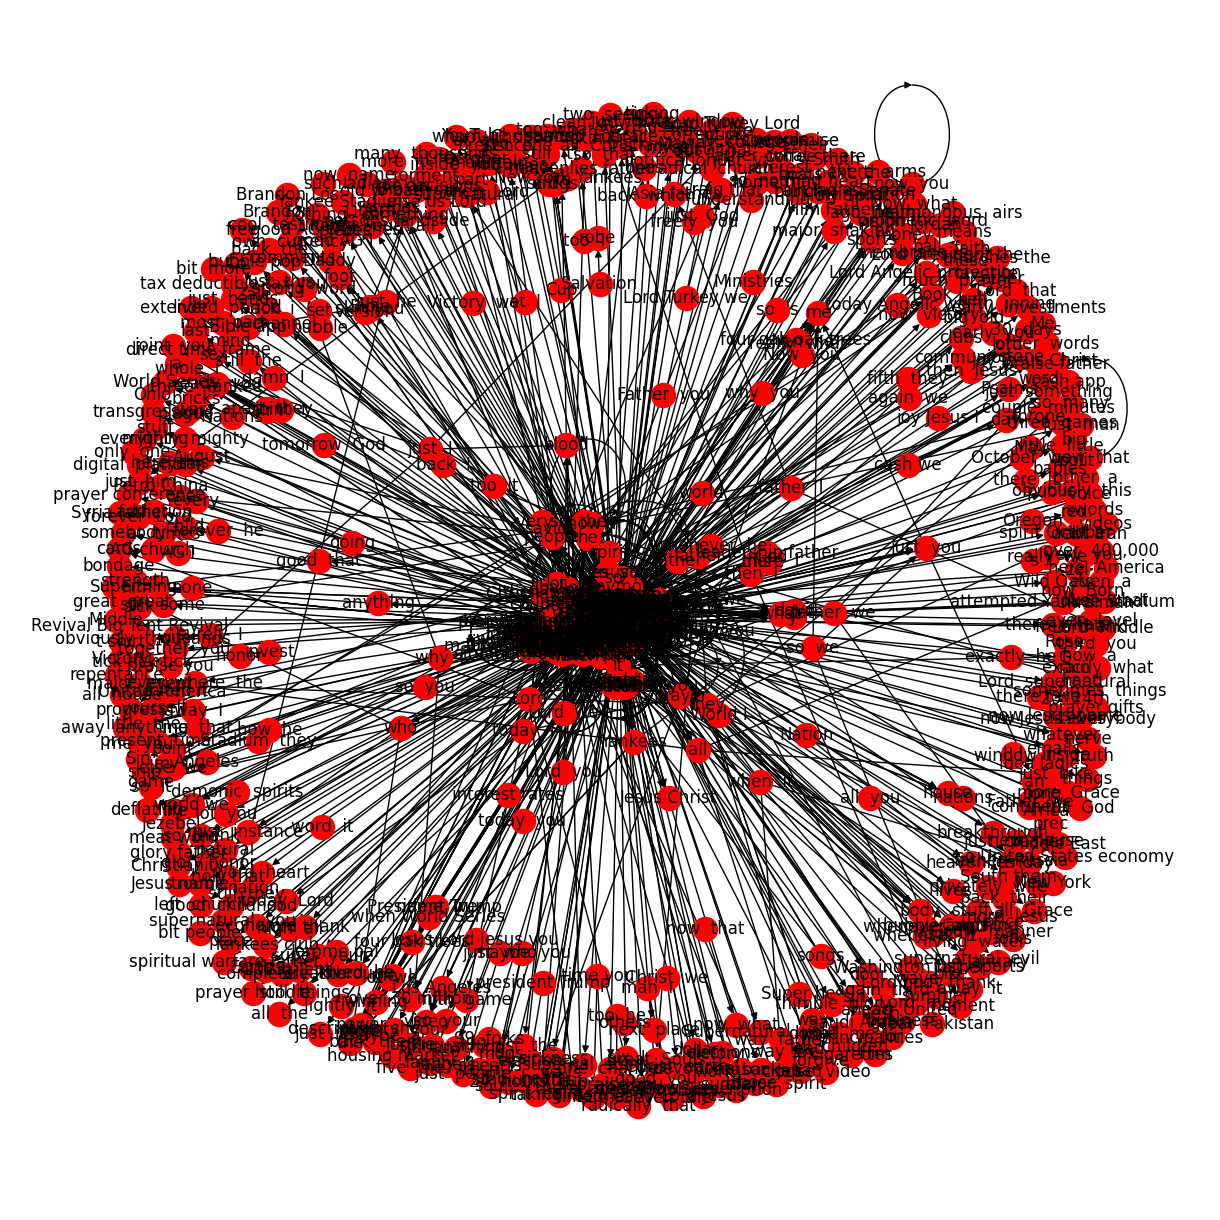

In [52]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

In [58]:
kg_df[kg_df['edge']=="going"]

,source,target,edge
3,we,heart,going
36,it,ticking,going
118,Yankees,the,going
129,pastor I,,going
169,I,obviously thousands,going
210,Yankees,,going
222,going,only one,going
251,,six I,going
320,whenever I,,going
357,I,you,going


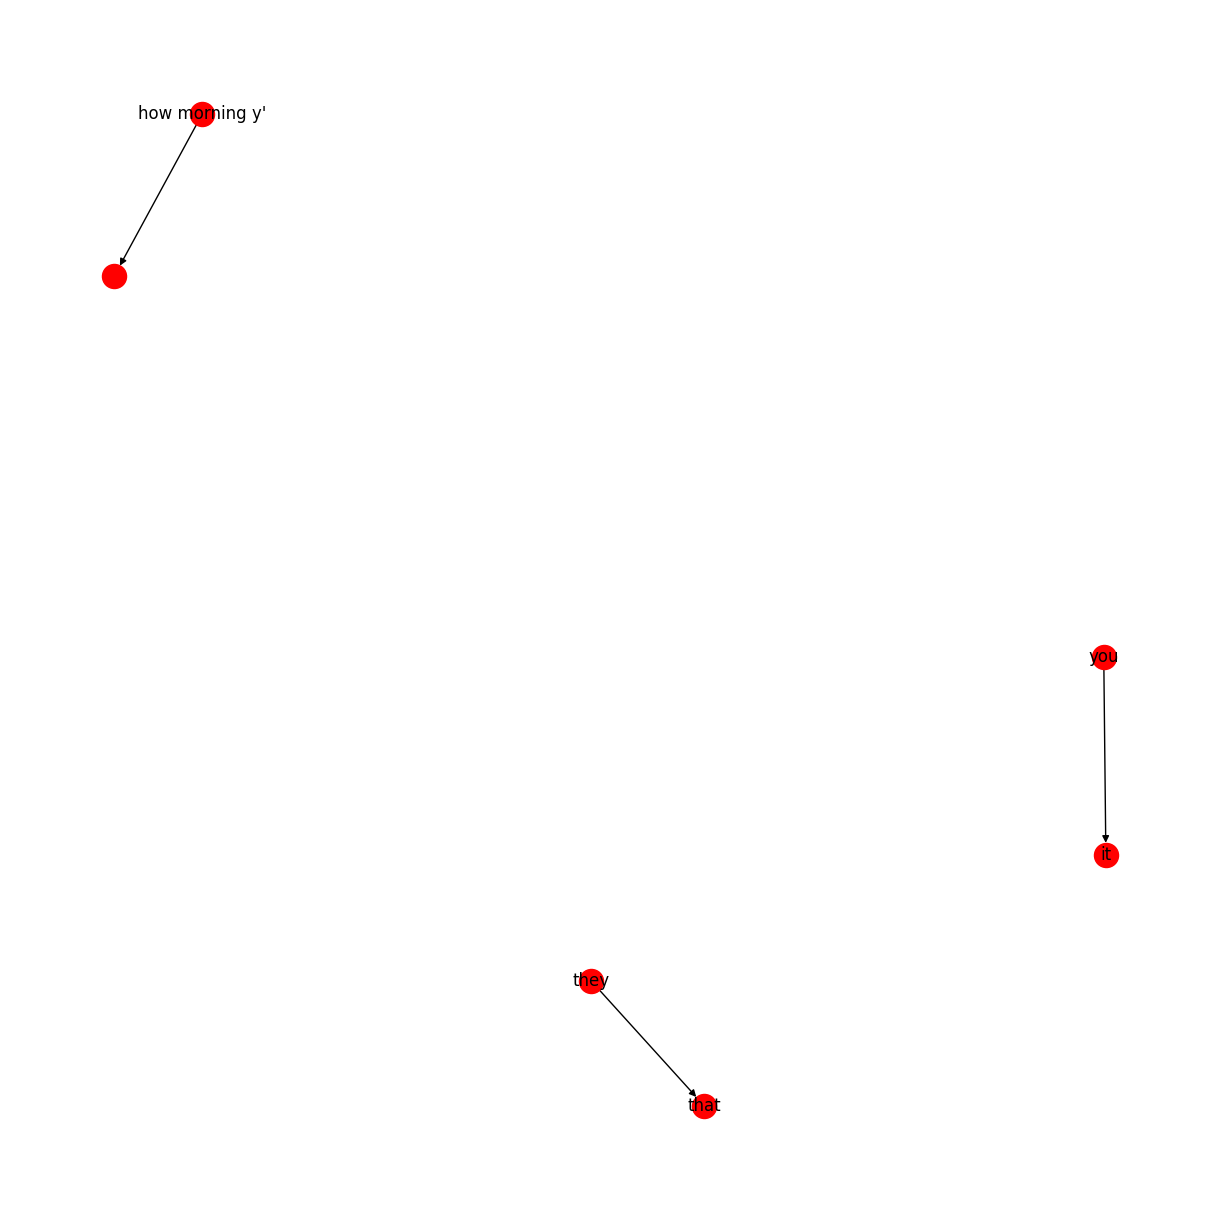

In [59]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="doing"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
# nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:



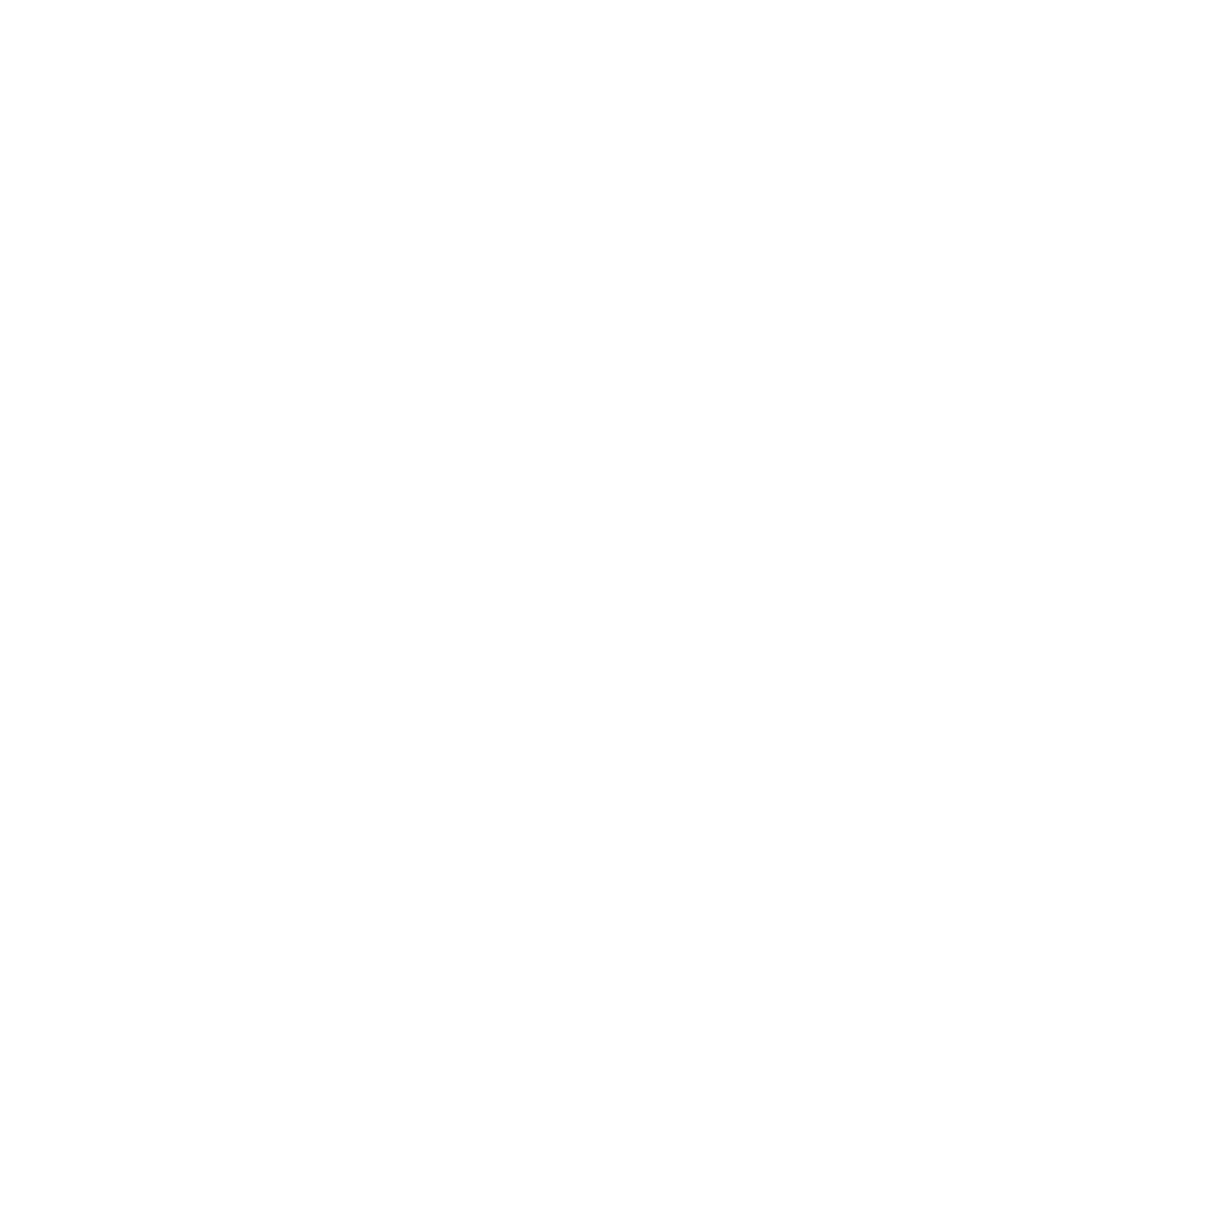

In [42]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:



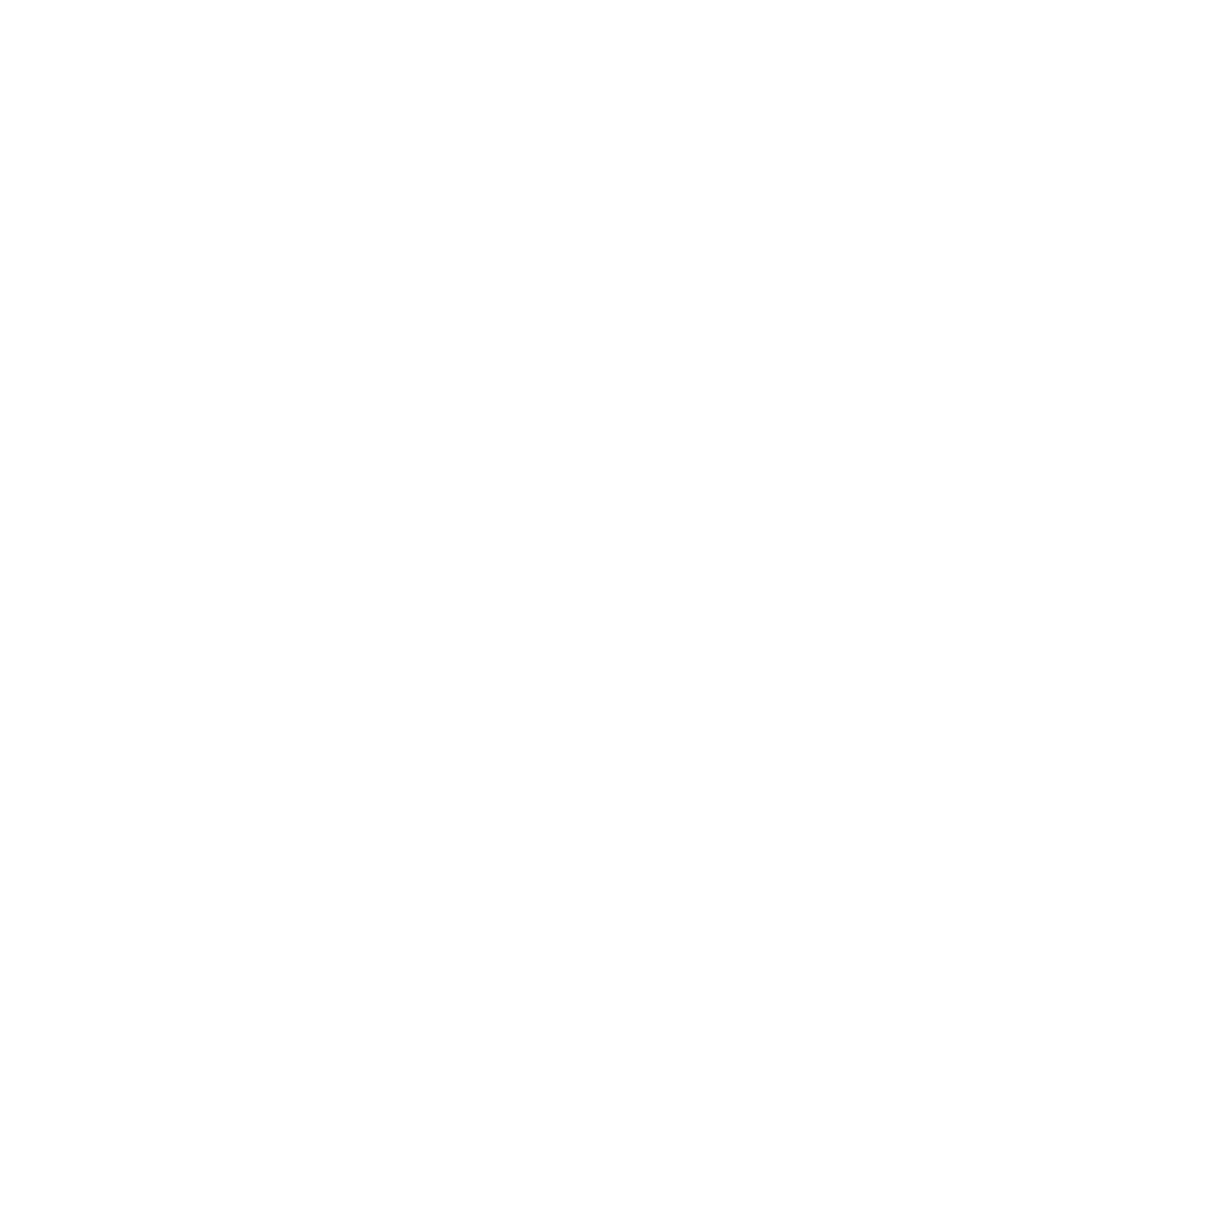

In [43]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()